# Import libraries and set configs

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, confusion_matrix, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password

from datetime import datetime


class CFG:
    load = True
    historical = False
    create_dataset = True
    update_dataset = True
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    optimize_alpha = 0.05
    n_repeats = 1
    n_folds = 8
    last_date = datetime.strptime("2024-05-06:9:00:00", "%Y-%m-%d:%H:%M:%S")
    agg_periods = [24, 72]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

Timeframe is 1h/4h, trade type is buy
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:72: RuntimeWarning: coroutine 'Application.shutdown' was never awaited
  format_exception(function)
/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:72: RuntimeWarning: coroutine 'Application.initialize' was never awaited
  format_exception(function)



Load the datasets...
ByBitPerpetual
10000000AIDOGEUSDT
1000000MOGUSDT
10000COQUSDT
10000LADYSUSDT
10000NFTUSDT
10000SATSUSDT
10000STARLUSDT
10000WENUSDT
1000BEERUSDT
1000BONKUSDT
1000BTTUSDT
1000FLOKIUSDT
1000IQ50USDT
1000LUNCUSDT
1000PEPEUSDT
1000RATSUSDT
1000TURBOUSDT
1000XECUSDT
1CATUSDT
1INCHUSDT
AAVEUSDT
ACEUSDT
ACHUSDT
ADAUSDT
AERGOUSDT
AEVOUSDT
AGIUSDT
AGIXUSDT
AGLDUSDT
AIUSDT
AKROUSDT
ALGOUSDT
ALICEUSDT
ALPACAUSDT
ALPHAUSDT
ALTUSDT
AMBUSDT
ANKRUSDT
ANTUSDT
APEUSDT
API3USDT
APTUSDT
ARBUSDT
ARKMUSDT
ARKUSDT
ARPAUSDT
ARUSDT
ASTRUSDT
ATAUSDT
ATOMUSDT
AUCTIONUSDT
AUDIOUSDT
AVAXUSDT
AXLUSDT
AXSUSDT
BADGERUSDT
BAKEUSDT
BALUSDT
BANDUSDT
BATUSDT
BBUSDT
BCHUSDT
BEAMUSDT
BELUSDT
BENDOGUSDT
BICOUSDT
BIGTIMEUSDT
BLURUSDT
BLZUSDT
BNBUSDT
BNTUSDT
BNXUSDT
BOBAUSDT
BOMEUSDT
BONDUSDT
BRETTUSDT
BSVUSDT
BSWUSDT
BTCUSDT
C98USDT
CAKEUSDT
CANTOUSDT
CEEKUSDT
CELOUSDT
CELRUSDT
CETUSUSDT
CFXUSDT
CHRUSDT
CHZUSDT
CKBUSDT
COMBOUSDT
COMPUSDT
COREUSDT
COSUSDT
COTIUSDT
COVALUSDT
CROUSDT
CRVUSDT
CTCUSDT
CTKUS

100%|██████████| 1/1 [47:29<00:00, 2849.97s/it]


,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,STOCH_RSI_Volume24,14,35,9,7,3,25,0.9363,0.9161,0.9067,0.9191,0.9283,0.9416,0.9653,0.9641,0.9666,0.9764,0.9773,0.9865,0.9911,0.9918,0.9955,1.0008,1.0099,1.0232,1.0305,1.0379,1.0454,1.0467,1.0482,1.048,-0.41,-0.84,-1.24,-1.64,-2.05,-2.45,-2.87,-3.29,-3.71,-4.16,-4.67,-5.27,-64.56,-2629.28,-2841.73,-3822.71,-6930.38,-11489.06,-12114.56,-12936.54,-13835.59,-14916.43,-23756.02,-25058.43,52705


### Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

Timeframe is 1h/4h, trade type is sell
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:72: RuntimeWarning: coroutine 'Application.shutdown' was never awaited
  format_exception(function)
/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:72: RuntimeWarning: coroutine 'Application.initialize' was never awaited
  format_exception(function)
100%|██████████| 1/1 [05:19<00:00, 319.02s/it]


,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,STOCH_RSI_Volume24,14,35,9,7,3,25,0.9469,0.8963,0.8688,0.851,0.8274,0.8171,0.8046,0.7937,0.7882,0.7787,0.7683,0.7597,0.7605,0.7597,0.76,0.7598,0.7559,0.7531,0.7464,0.7412,0.7384,0.7371,0.7347,0.7362,0.44,0.86,1.27,1.68,2.07,2.46,2.84,3.21,3.56,3.91,4.25,4.57,4.86,5.1,5.3,5.46,5.58,5.68,5.75,5.78,5.78,5.76,5.73,5.72,40548


# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/3304 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

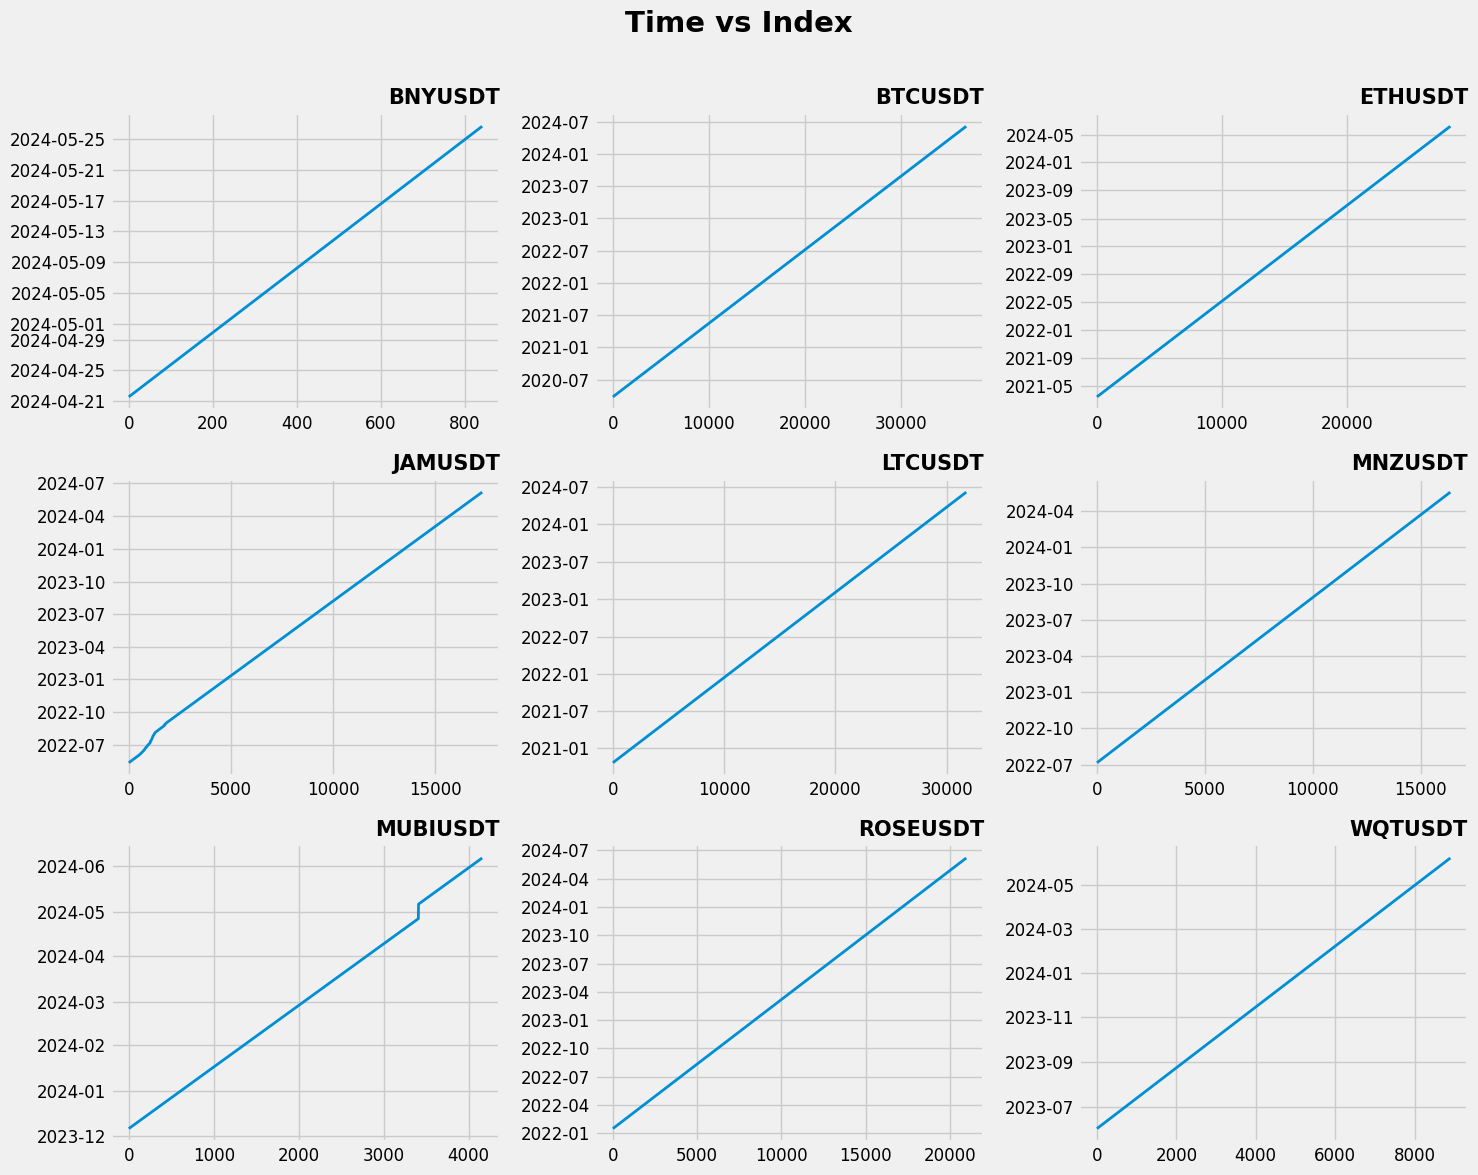

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel('')
        plt.yticks(fontsize=12) 
        ax.set_xlabel('')
        plt.xticks(fontsize=12)
        # ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
price_cols = ['open','high', 'low', 'close']
real_price_cols = ['real_high', 'real_low', 'real_close']
funding_cols = ['funding_rate']
rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, '', '', 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df = df.drop(columns=['close_smooth'])
    df = df.drop(columns=[c for c in df.columns if c.endswith('_dir')])
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df = df.ffill()
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    # # add aggregate values
    # for col in ['close', 'btcd_close', 'btcdom_close']:
    #     for period in CFG.agg_periods:
    #         for agg_func in CFG.agg_funcs:
    #             df[f'{col}_{agg_func.__name__}_{period}'] = df[col].rolling(period, min_periods=1).agg({'func': agg_func})
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step, train_df_prev=None):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load max time for that ticker from the previously created dataset
        if train_df_prev is not None:
            max_time = train_df_prev.loc[train_df_prev['ticker'] == ticker, 'time'].max()
        else:
            max_time = None
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            if max_time and t <= max_time:
                continue
            
            pass_cycle = False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                continue
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set 
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row['target'] = 1
                    break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price

                    if l1 or l2:
                        row['target'] = 1
            
            if pass_cycle:
                continue
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 272
# for how long time (in hours) we want to predict
target_offset = 96

if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 16, 17, 22, 23]
    df = df[df['time'].dt.hour.isin(buy_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
        except FileNotFoundError:
            pass
    # dataset for model training
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step, train_df_prev)
    train_buy = train_buy.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_buy = pd.concat([train_df_prev, train_buy]).reset_index(drop=True)
    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [0, 4, 9, 14, 16, 17, 18, 19, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(sell_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')
        except FileNotFoundError:
            pass
    # dataset for model training
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step, train_df_prev)
    train_sell = train_sell.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_sell = pd.concat([train_df_prev, train_sell]).reset_index(drop=True)
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    display(train_sell.head())
    display(train_sell.shape)
    
    # this is made for tests
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, 'buy', configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values('time').reset_index(drop=True)

    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, 'sell', configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values('time').reset_index(drop=True)

    del df

  0%|          | 0/1598 [00:00<?, ?it/s]

,time,open,high,low,close,volume,funding_rate,rsi,stoch_slowk,stoch_slowd,stoch_diff,atr,cci,sar,linear_reg,linear_reg_angle,macd,macdhist,macdsignal,btcd_open,btcd_high,btcd_low,btcd_close,btcd_volume,btcdom_open,btcdom_high,btcdom_low,btcdom_close,btcdom_volume,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_diff_prev_4,atr_prev_4,cci_prev_4,sar_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macdsignal_prev_4,btcdom_open_prev_4,btcdom_high_prev_4,btcdom_low_prev_4,btcdom_close_prev_4,btcdom_volume_prev_4,ticker,pattern,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,funding_rate_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_diff_prev_8,atr_prev_8,cci_prev_8,sar_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macdsignal_prev_8,btcdom_open_prev_8,btcdom_high_prev_8,btcdom_low_prev_8,btcdom_close_prev_8,btcdom_volume_prev_8,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_diff_prev_12,atr_prev_12,cci_prev_12,sar_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macdsignal_prev_12,btcdom_open_prev_12,btcdom_high_prev_12,btcdom_low_prev_12,btcdom_close_prev_12,btcdom_volume_prev_12,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,funding_rate_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_diff_prev_16,atr_prev_16,cci_prev_16,sar_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macdsignal_prev_16,btcdom_open_prev_16,btcdom_high_prev_16,btcdom_low_prev_16,btcdom_close_prev_16,btcdom_volume_prev_16,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_diff_prev_20,atr_prev_20,cci_prev_20,sar_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macdsignal_prev_20,btcdom_open_prev_20,btcdom_high_prev_20,btcdom_low_prev_20,btcdom_close_prev_20,btcdom_volume_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,funding_rate_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_diff_prev_24,atr_prev_24,cci_prev_24,sar_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macdsignal_prev_24,btcd_open_prev_24,btcd_high_prev_24,btcd_low_prev_24,btcd_close_prev_24,btcd_volume_prev_24,btcdom_open_prev_24,btcdom_high_prev_24,btcdom_low_prev_24,btcdom_close_prev_24,btcdom_volume_prev_24,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_diff_prev_28,atr_prev_28,cci_prev_28,sar_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macdsignal_prev_28,btcdom_open_prev_28,btcdom_high_prev_28,btcdom_low_prev_28,btcdom_close_prev_28,btcdom_volume_prev_28,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,funding_rate_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_diff_prev_32,atr_prev_32,cci_prev_32,sar_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macdsignal_prev_32,btcdom_open_prev_32,btcdom_high_prev_32,btcdom_low_prev_32,btcdom_close_prev_32,btcdom_volume_prev_32,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_diff_prev_36,atr_prev_36,cci_prev_36,sar_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macdsignal_prev_36,btcdom_open_prev_36,btcdom_high_prev_36,btcdom_low_prev_36,btcdom_close_prev_36,btcdom_volume_prev_36,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,funding_rate_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_diff_prev_40,atr_prev_40,cci_prev_40,sar_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macdsignal_prev_40,btcdom_open_prev_40,btcdom_high_prev_40,btcdom_low_prev_40,...,low_prev_232,close_prev_232,volum

(15143, 1561)

  0%|          | 0/1505 [00:00<?, ?it/s]

,time,open,high,low,close,volume,funding_rate,rsi,stoch_slowk,stoch_slowd,stoch_diff,atr,cci,sar,linear_reg,linear_reg_angle,macd,macdhist,macdsignal,btcd_open,btcd_high,btcd_low,btcd_close,btcd_volume,btcdom_open,btcdom_high,btcdom_low,btcdom_close,btcdom_volume,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_diff_prev_4,atr_prev_4,cci_prev_4,sar_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macdsignal_prev_4,btcdom_open_prev_4,btcdom_high_prev_4,btcdom_low_prev_4,btcdom_close_prev_4,btcdom_volume_prev_4,ticker,pattern,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,funding_rate_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_diff_prev_8,atr_prev_8,cci_prev_8,sar_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macdsignal_prev_8,btcdom_open_prev_8,btcdom_high_prev_8,btcdom_low_prev_8,btcdom_close_prev_8,btcdom_volume_prev_8,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_diff_prev_12,atr_prev_12,cci_prev_12,sar_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macdsignal_prev_12,btcdom_open_prev_12,btcdom_high_prev_12,btcdom_low_prev_12,btcdom_close_prev_12,btcdom_volume_prev_12,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,funding_rate_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_diff_prev_16,atr_prev_16,cci_prev_16,sar_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macdsignal_prev_16,btcdom_open_prev_16,btcdom_high_prev_16,btcdom_low_prev_16,btcdom_close_prev_16,btcdom_volume_prev_16,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_diff_prev_20,atr_prev_20,cci_prev_20,sar_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macdsignal_prev_20,btcdom_open_prev_20,btcdom_high_prev_20,btcdom_low_prev_20,btcdom_close_prev_20,btcdom_volume_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,funding_rate_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_diff_prev_24,atr_prev_24,cci_prev_24,sar_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macdsignal_prev_24,btcd_open_prev_24,btcd_high_prev_24,btcd_low_prev_24,btcd_close_prev_24,btcd_volume_prev_24,btcdom_open_prev_24,btcdom_high_prev_24,btcdom_low_prev_24,btcdom_close_prev_24,btcdom_volume_prev_24,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_diff_prev_28,atr_prev_28,cci_prev_28,sar_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macdsignal_prev_28,btcdom_open_prev_28,btcdom_high_prev_28,btcdom_low_prev_28,btcdom_close_prev_28,btcdom_volume_prev_28,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,funding_rate_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_diff_prev_32,atr_prev_32,cci_prev_32,sar_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macdsignal_prev_32,btcdom_open_prev_32,btcdom_high_prev_32,btcdom_low_prev_32,btcdom_close_prev_32,btcdom_volume_prev_32,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_diff_prev_36,atr_prev_36,cci_prev_36,sar_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macdsignal_prev_36,btcdom_open_prev_36,btcdom_high_prev_36,btcdom_low_prev_36,btcdom_close_prev_36,btcdom_volume_prev_36,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,funding_rate_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_diff_prev_40,atr_prev_40,cci_prev_40,sar_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macdsignal_prev_40,btcdom_open_prev_40,btcdom_high_prev_40,btcdom_low_prev_40,...,low_prev_232,close_prev_232,volum

(13496, 1561)

  0%|          | 0/870 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
train_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values('time')

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if 'prev' not in c and 'sar' in c]

# Data tests

### Test train dataframe columns

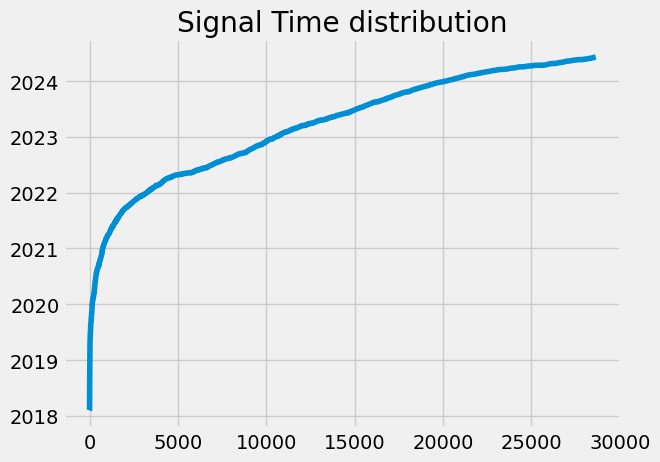

In [10]:
import re

if CFG.create_dataset:
    # check if train dataset has only columns that we expect
    cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)

    agg_funcs = ['amin', 'amax', 'mean', 'median', 'std']
    agg_cols = [c for c in cols if len(c.split('_')) > 2 and c.split('_')[-2] in agg_funcs]

    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + agg_cols + ['atr', 'cci', 'sar', 'volume', 'pattern', 'target', 'ticker', 'ttype'])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if 'volume' in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
    for f_c in funding_cols_:
        num = ''.join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
    for b_c in btcd_cols_:
        pass_cycle = False
        for a_c in agg_funcs:
            if a_c in b_c:
                pass_cycle = True
                break
        if pass_cycle:
            continue
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = ''.join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = ''.join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df['time'].plot(title='Signal Time distribution')


### Test buy target corectness

In [11]:
prev_ticker = None

train_buy_ = train_buy[train_buy['ticker'] == 'MILOUSDT']

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']
        if ticker != 'MILOUSDT':
            continue

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                try:
                    assert first_signal > first_anti_signal
                except AssertionError:
                    pass

  0%|          | 0/15143 [00:00<?, ?it/s]

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

  0%|          | 0/13496 [00:00<?, ?it/s]

### Test pattern / target distribution

In [13]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt = pvt.rename(columns={'pattern': 'count'})
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Buy')
display(pvt)
display(train_buy['ttype'].value_counts())
display(train_buy[['target', 'pattern']].value_counts())
display(train_buy[['target', 'pattern']].value_counts(normalize=True))

pvt = train_sell
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt = pvt.rename(columns={'pattern': 'count'})
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Sell')
display(pvt)
display(train_sell['ttype'].value_counts())
display(train_sell[['target', 'pattern']].value_counts())
display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,1048,1825,0.574247,"(0.5517, 0.5968)"
3,1,1,1114,2064,0.539729,"(0.5183, 0.5611)"
5,2,1,1136,2064,0.550388,"(0.529, 0.5717)"
7,3,1,1234,2296,0.537456,"(0.5172, 0.5577)"
9,16,1,913,1762,0.518161,"(0.4949, 0.5414)"
11,17,1,926,1744,0.530963,"(0.5077, 0.5543)"
13,22,1,965,1806,0.534330,"(0.5114, 0.5572)"
15,23,1,903,1582,0.570796,"(0.5465, 0.5951)"


buy    15143
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    8239
0       STOCH_RSI_Volume24    6904
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.54408
0       STOCH_RSI_Volume24    0.45592
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
1,0,1,514,970,0.529897,"(0.4986, 0.5611)"
3,4,1,847,1643,0.515520,"(0.4915, 0.5396)"
5,9,1,799,1488,0.536962,"(0.5118, 0.5622)"
7,14,1,832,1568,0.530612,"(0.506, 0.5552)"
9,16,1,675,1274,0.529827,"(0.5026, 0.5571)"
11,17,1,576,1053,0.547009,"(0.5171, 0.5769)"
13,18,1,532,1031,0.516004,"(0.4857, 0.5464)"
15,19,1,575,1103,0.521306,"(0.492, 0.5506)"
17,21,1,630,1182,0.532995,"(0.5047, 0.5613)"
19,22,1,575,1098,0.523679,"(0.4943, 0.5531)"


sell    13496
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    7154
0       STOCH_RSI_Volume24    6342
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.530083
0       STOCH_RSI_Volume24    0.469917
dtype: float64

# Data visualization

### Plot ratio of class 1 for every month

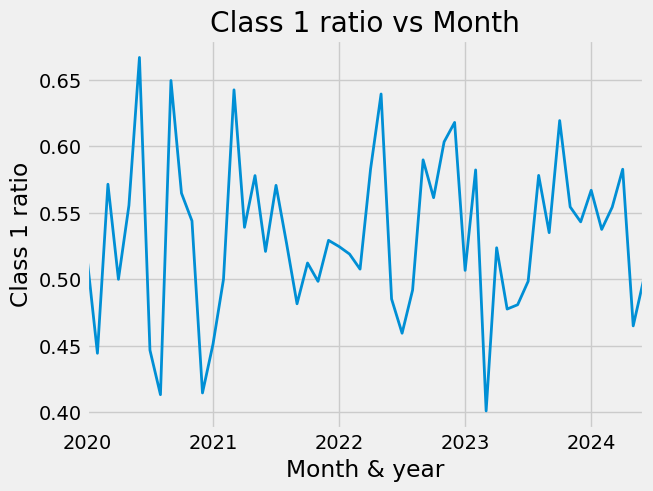

In [14]:
train_df['date_month'] = train_df['time'].dt.to_period('M')
group_df = train_df[train_df['time'].dt.year >= 2020]
ax = group_df.groupby('date_month')['target'].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel('Month & year')
ax.set_ylabel('Class 1 ratio')
ax.set_title('Class 1 ratio vs Month')
train_df = train_df.drop(columns='date_month')

### Visualize buy trades

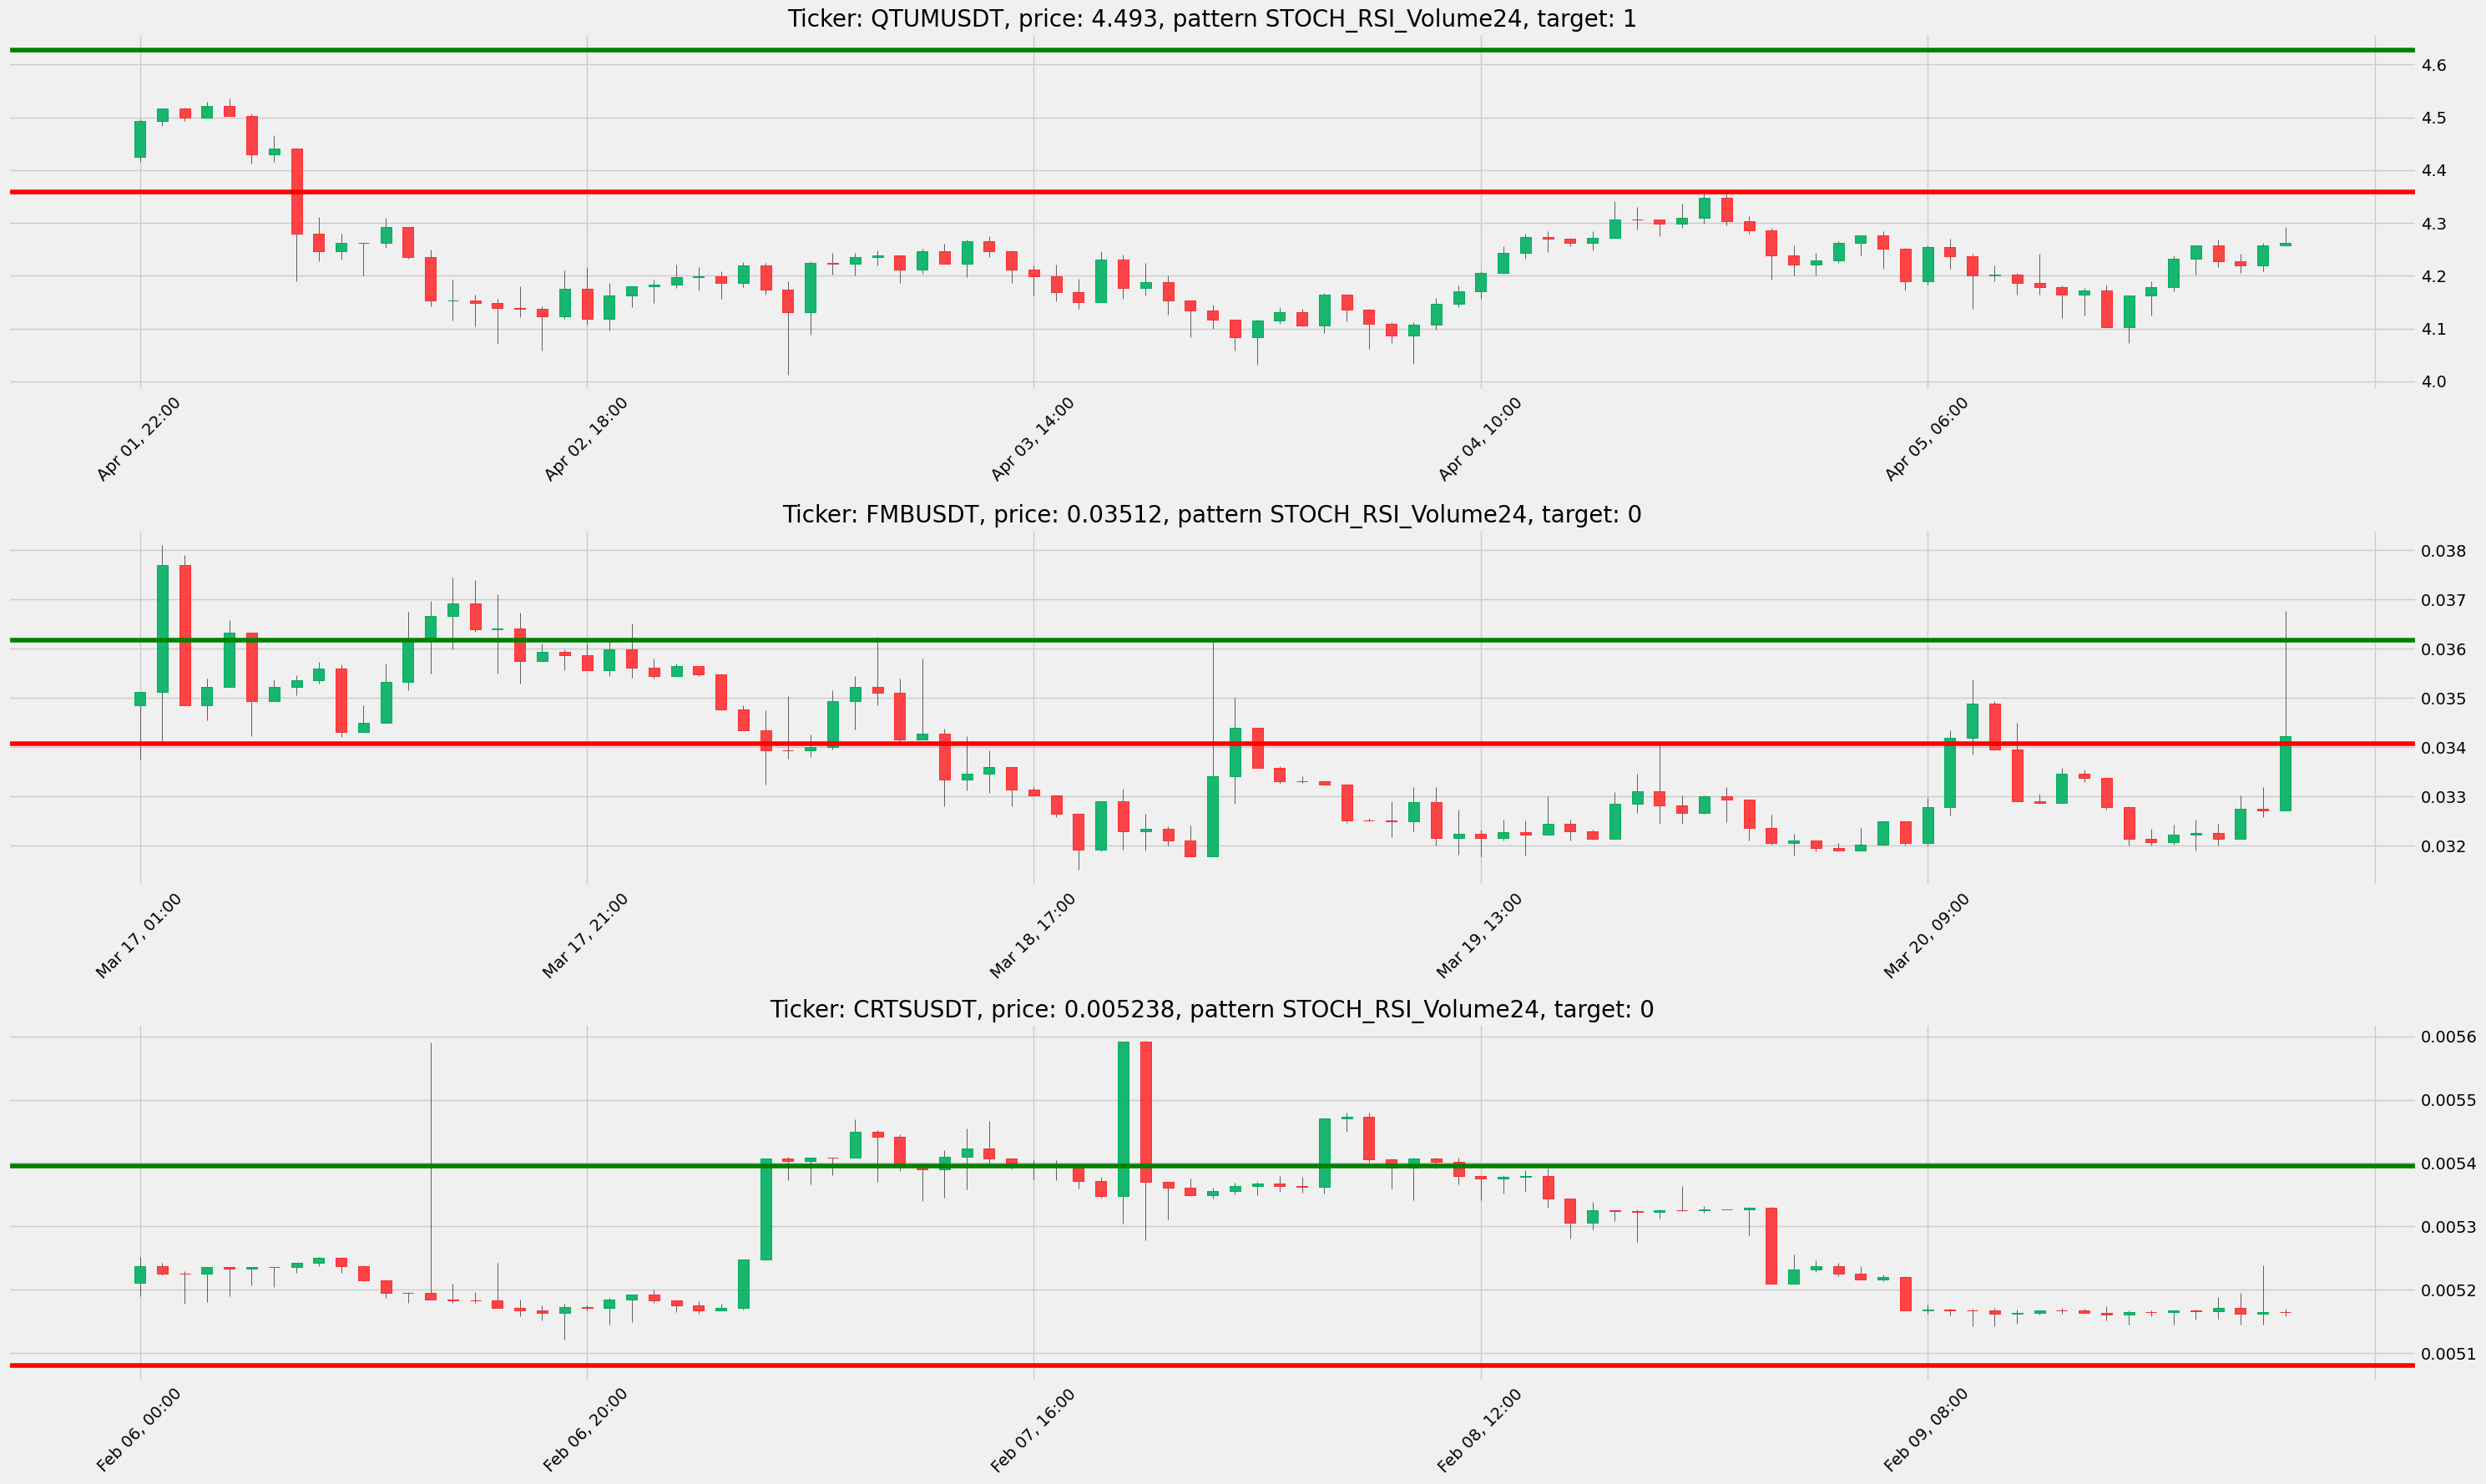

In [15]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:

    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)


    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

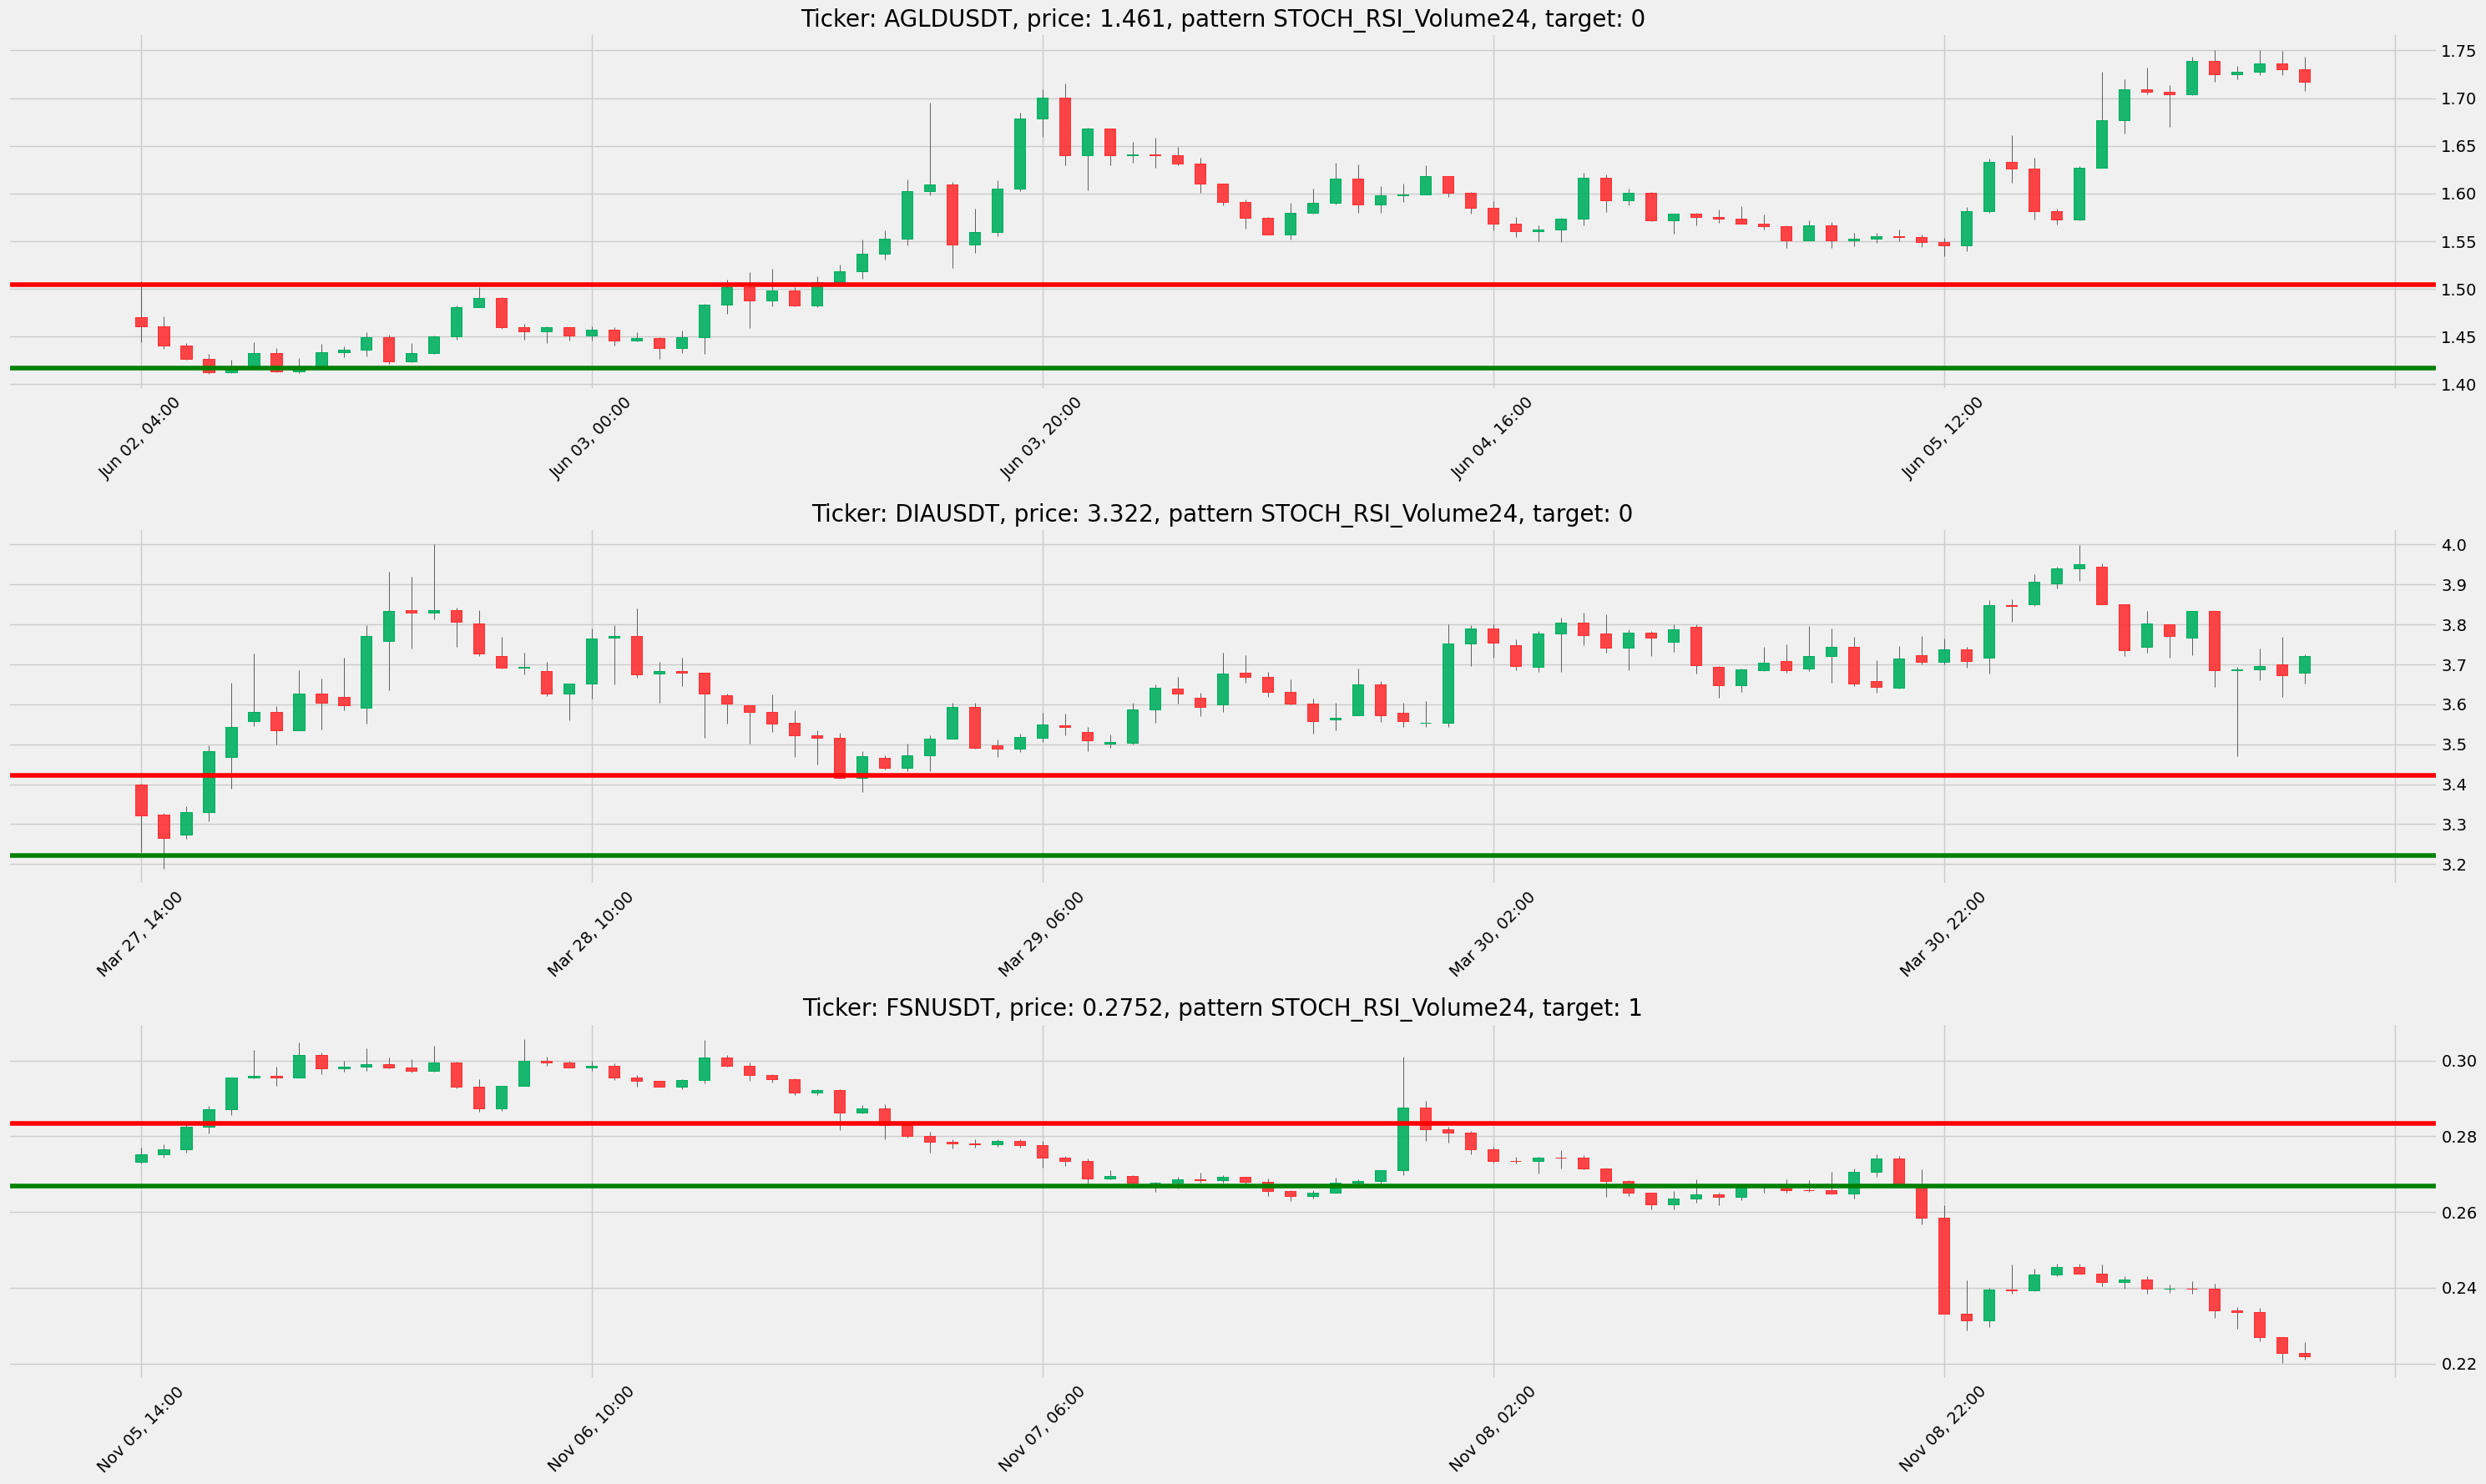

In [16]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

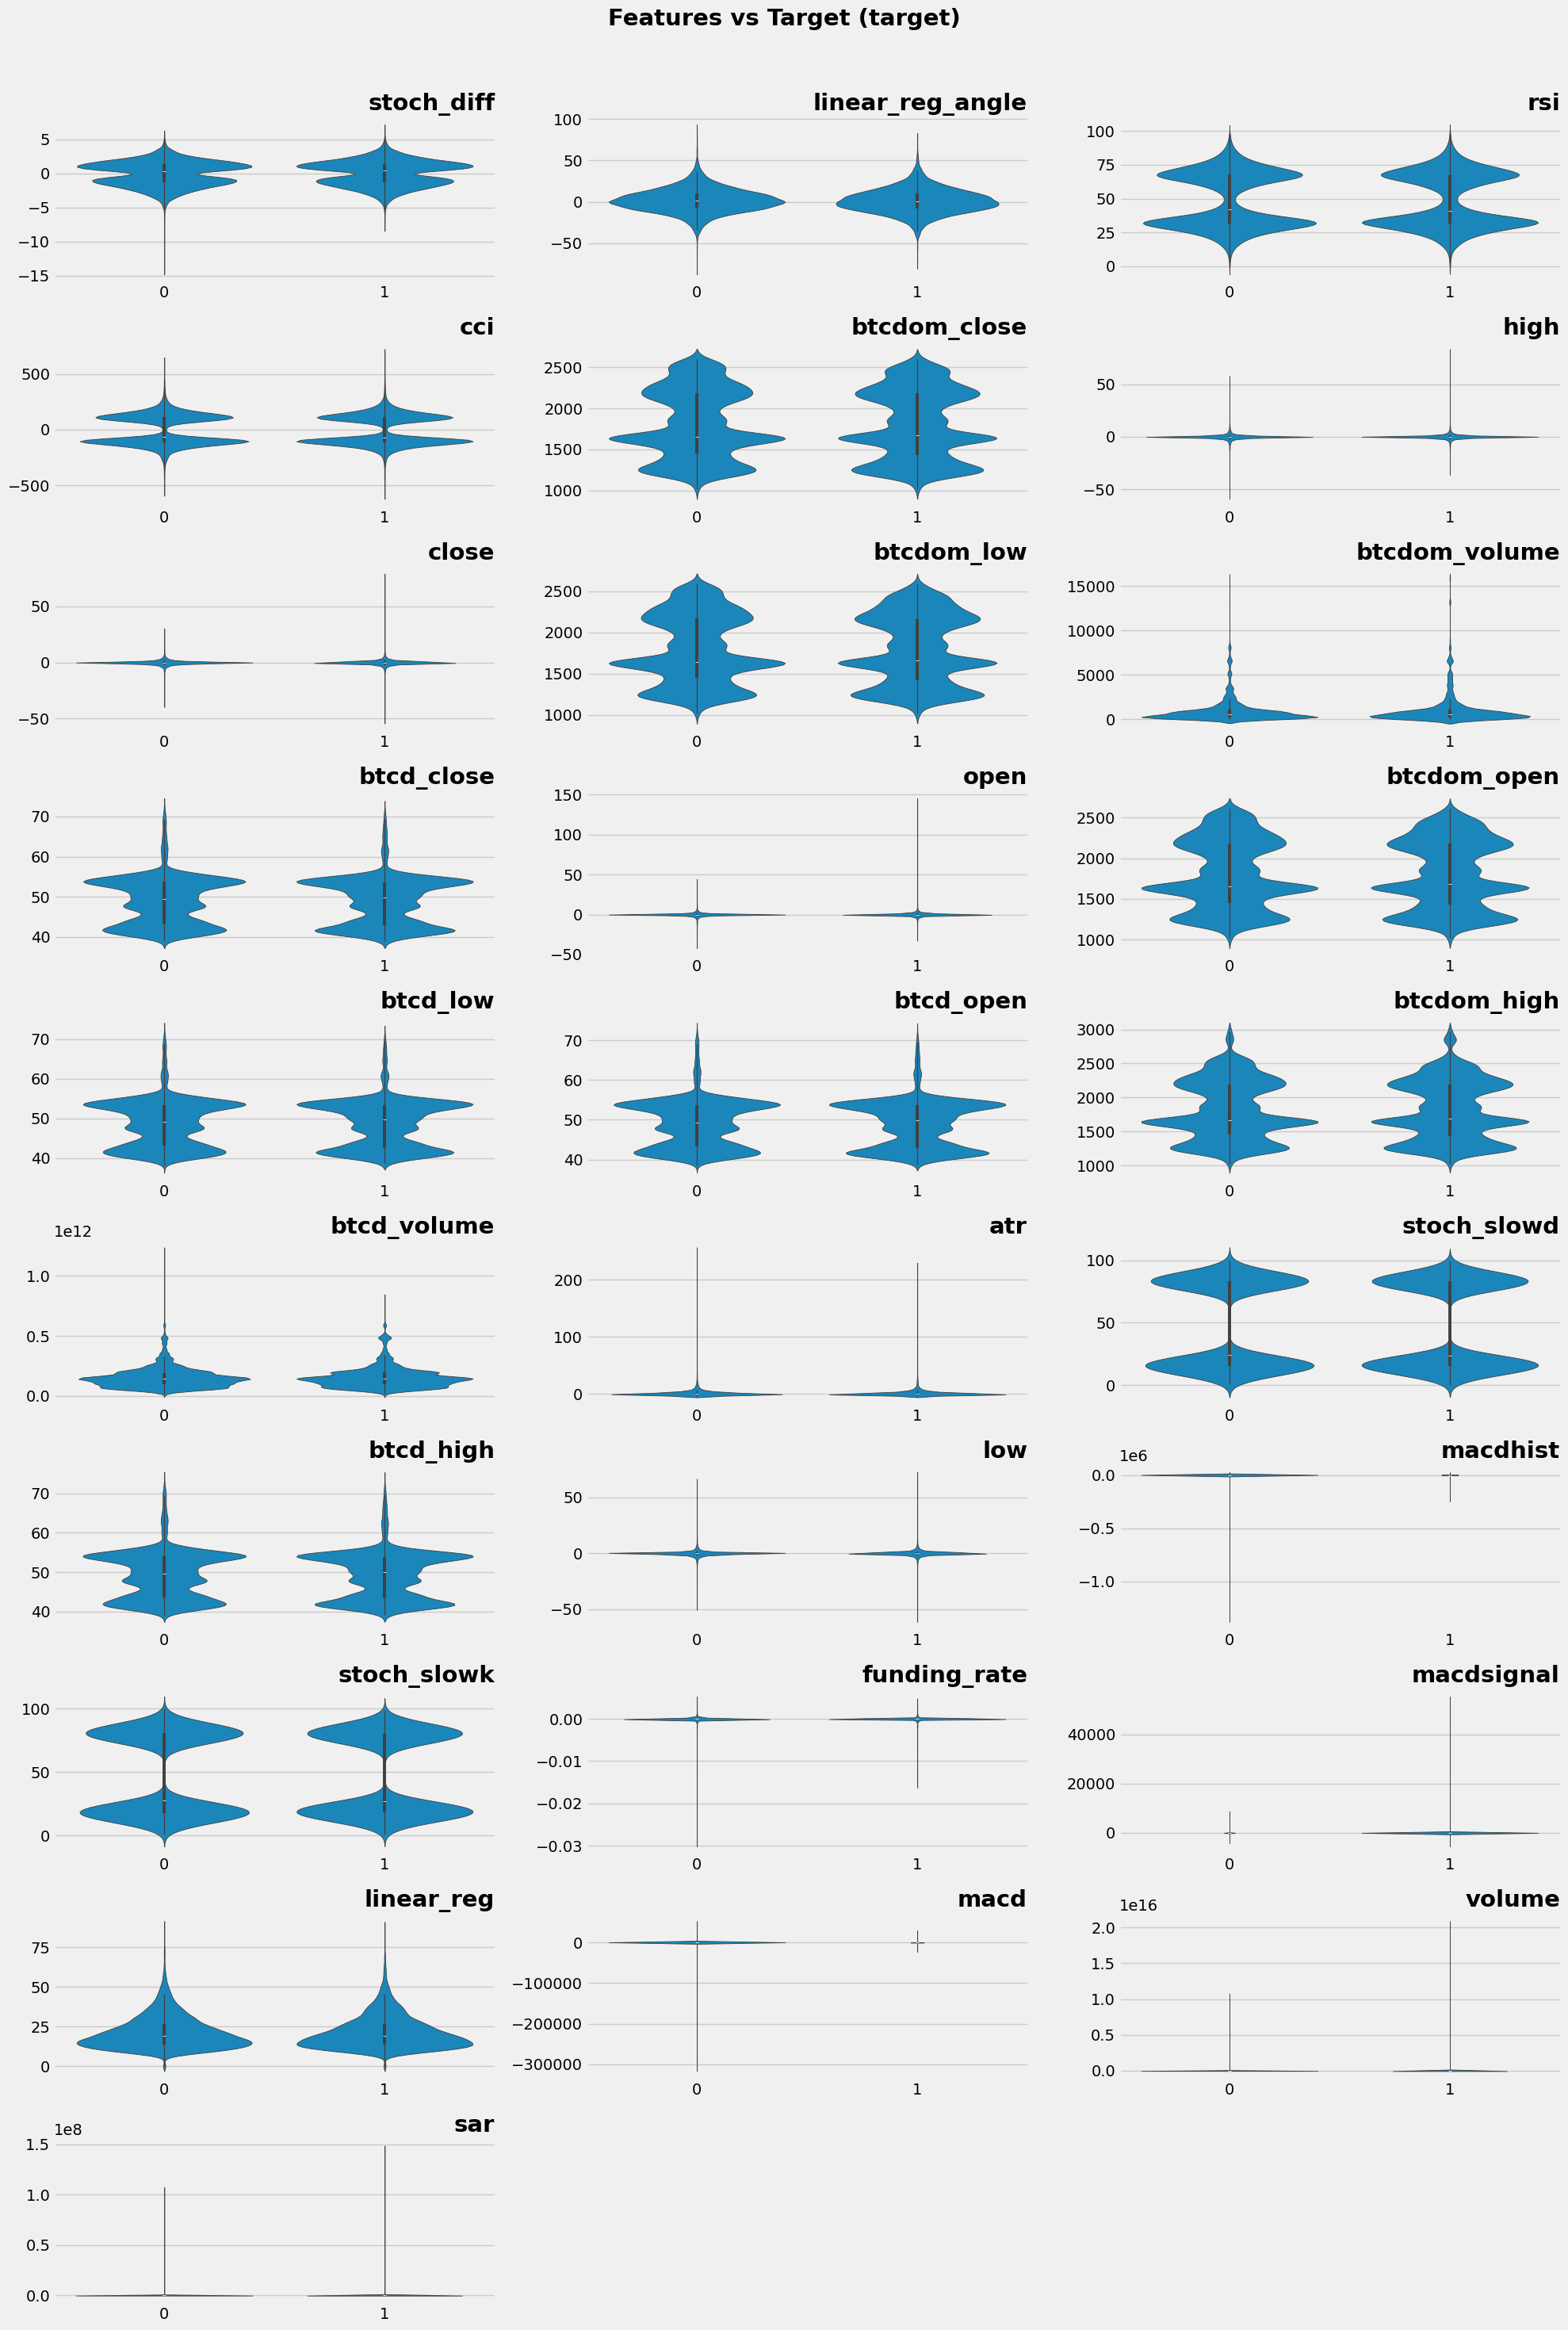

In [17]:
fi = pd.read_csv(f'model/feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target')

### Show the last signals

In [18]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(35)

,time,ticker,ttype,pattern
93218,2024-06-06 03:00:00,LESBIANUSDT,buy,STOCH_RSI_Volume24
93219,2024-06-06 04:00:00,LTCUSDT,sell,STOCH_RSI_Volume24
93220,2024-06-06 04:00:00,TETUSDT,sell,STOCH_RSI_Volume24
93221,2024-06-06 04:00:00,POWRUSDT,sell,STOCH_RSI_Volume24
93222,2024-06-06 04:00:00,VELOUSDT,sell,STOCH_RSI_Volume24
93223,2024-06-06 04:00:00,HIVEUSDT,sell,STOCH_RSI_Volume24
93224,2024-06-06 04:00:00,APFCUSDT,sell,STOCH_RSI_Volume24
93225,2024-06-06 04:00:00,BCHUSDT,sell,STOCH_RSI_Volume24
93226,2024-06-06 04:00:00,GMXUSDT,sell,STOCH_RSI_Volume24
93227,2024-06-06 04:00:00,STXUSDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [19]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'auc'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]


def ppv_npv_acc(y_true, y_pred):
    """ Calculate confusion matrix and return harmonic mean score of Positive Predictive Value (PPV, precisoin) and Negative Predictive Value (NPV) """
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        return 0
    return (tp + tn) / (tp + fp + tn + fn + 1e-8)

def ppv_npv_acc_lgbm(y_true, y_pred):
    """ Metric for LGBM """
    return 'ppv_npv_acc', ppv_npv_acc(y_true, y_pred), False


def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=1000)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric='logloss', 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError:
            break

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [20]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric='logloss', 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [21]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [22]:
if CFG.select_features:
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']],
                    boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'model/feature_importance.csv', index=False)
else:
    fi = pd.read_csv(f'model/feature_importance.csv')

# Train

### Load selected features

In [23]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['corr', 'rank'], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations['corr'] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num, corr_thresh):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit() and period[-2] == 'prev':
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])
    
    # select only features with low correlation
    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    features = list(features) + ['weekday']
    
    # remove highly correlated features from the feature dict
    feature_dict['features'] = features

    for item in feature_dict.items():
        if not isinstance(item[0], int):
            continue

        features_to_remove = list()

        for f in item[1]:
            if item[0] > 0:
                f_ = f'{f}_prev_{item[0]}'
            else:
                f_ = f
            
            if f_ not in features:
                assert f_ in features_to_exclude
                features_to_remove.append(f)
        
        feature_dict[item[0]] = [f for f in feature_dict[item[0]] if f not in features_to_remove]

    # remove empty lists from feature_dict
    empty_list_keys = list()
    
    for key in feature_dict:
        if not feature_dict[key]:
            empty_list_keys.append(key)
            
    for key in empty_list_keys:
        del feature_dict[key]

    return features, feature_dict

feature_num = 52
corr_thresh = 0.7730816638791603

train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv('model/feature_importance.csv')
features, feature_dict = prepare_features(fi, feature_num, corr_thresh)
assert len(features) == len(set(features))

display(features, len(features))

['stoch_diff',
 'linear_reg_angle',
 'rsi',
 'btcdom_close',
 'high',
 'close',
 'btcdom_volume_prev_4',
 'stoch_diff_prev_4',
 'stoch_slowd_prev_8',
 'btcdom_volume_prev_20',
 'btcd_volume_prev_24',
 'btcdom_volume_prev_28',
 'stoch_diff_prev_28',
 'rsi_prev_36',
 'btcdom_volume_prev_40',
 'btcdom_volume_prev_56',
 'rsi_prev_68',
 'btcdom_volume_prev_68',
 'high_prev_80',
 'btcd_volume_prev_96',
 'btcdom_volume_prev_100',
 'btcdom_volume_prev_104',
 'btcdom_volume_prev_108',
 'low_prev_112',
 'btcdom_volume_prev_116',
 'btcdom_volume_prev_124',
 'btcdom_volume_prev_128',
 'btcdom_volume_prev_136',
 'btcdom_volume_prev_140',
 'btcdom_volume_prev_148',
 'btcdom_volume_prev_152',
 'btcdom_volume_prev_156',
 'btcdom_volume_prev_164',
 'cci_prev_168',
 'btcdom_volume_prev_172',
 'btcdom_volume_prev_184',
 'btcd_volume_prev_192',
 'btcdom_volume_prev_192',
 'btcdom_volume_prev_196',
 'btcdom_volume_prev_200',
 'btcdom_volume_prev_216',
 'btcdom_volume_prev_220',
 'low_prev_224',
 'btcdom_vo

48

### Functions for train

In [24]:
from __future__ import annotations
from typing import Tuple
from scipy.stats import ttest_rel

with open(f'model/bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)
df_len = train_df.shape[0]

def conf_ppv_npv_acc_score(y: np.ndarray, oof: np.ndarray, 
                           low_bound: float, high_bound: float) -> Tuple[float, float, float]:
    """ 
    Consider only high confident objects and low confident 
    objects for PPV and NPV score calculation 
    """
    pred_conf = np.zeros_like(oof)
    pred_conf[oof >= high_bound] = 1
    pred_conf = pred_conf[(oof >= high_bound)]
    y_conf = y.values.reshape(-1,1)[(oof >= high_bound)]
    if y_conf.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf, pred_conf), y_conf.shape[0], y_conf.shape[0]/y.shape[0]

def model_train(df: pd.DataFrame, features: list, params: dict, 
                n_folds: int, low_bound: float, high_bound: float, 
                train_test: str, max_train_size: int = None, verbose: bool = False) -> Tuple[np.ndarray, lgb.LGBMClassifier, list] : 
    """
    Train/validate model, return: 
        - model
        - list of precisions for confident objects by folds (if train_test == 'fold')
        - list of profitable objects by folds (if train_test == 'fold')
    """
    X, time = df[features], df['time']
    y = df['target']
    conf_scores = list()
    conf_object_nums = list()
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=max_train_size, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            if fold == 0:
                val_idxs = val_idx.copy()
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
            oof[val_idx, 0] = val_preds[:,1]
        
            val_score = log_loss(y_val, val_preds)
            conf_score, conf_obj_num, conf_obj_pct = conf_ppv_npv_acc_score(y_val, val_preds[:, 1], low_bound, high_bound)
            conf_scores.append(conf_score)
            conf_object_nums.append(conf_obj_num)
            
            if verbose:
                print(f'Logloss: {val_score}, Confident objects score: {conf_score}\n'
                      f'Number of confident objects {conf_obj_num}, % of confident objects: {conf_obj_pct}\n'
                      f'Number of profitable objects: {round((2 * conf_score -  1) * conf_obj_num)}')
            
        return model_lgb, conf_scores, conf_object_nums, oof, val_idxs
    elif train_test == 'full' or train_test == 'inference':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return model_lgb, [], [], np.array([]), np.array([])


### Functions for optimization

In [25]:
def objective(trial: optuna.trial) -> float:
    """Optimize hyperparameters using Optuna"""
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precison',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt']), # ['dart', 'goss', 'gbdt']),   !!!
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10), # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

        # 'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                       # to larger value will give better training result but may increase train time 
        # 'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                         # categorical features, especially for 
                                                                         # categories with few data                                  
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                            
        'verbose': -1,
        'importance_type': 'gain',
        'high_bound': trial.suggest_float('high_bound', 0.5, 0.65),
        'low_bound': trial.suggest_float('low_bound', 0.0, 0.1),
        'feature_num': trial.suggest_int('feature_num', 30, 600),
        'corr_thresh': trial.suggest_float('corr_thresh', 0.5, 0.99)
    }
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    if params['is_unbalance'] == 'True':
        params['class_weight'] = trial.suggest_categorical('class_weight', ['balanced', None]), 

    high_bound = params['high_bound']
    del params['high_bound']

    low_bound = params['low_bound']
    del params['low_bound']

    corr_thresh = params['corr_thresh']
    del params['corr_thresh']
    
    fi = pd.read_csv(f'model/feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features, _ = prepare_features(fi, feature_num, corr_thresh)
    
    _, conf_scores, conf_object_nums, _, _ = model_train(train_df[train_df['time'] < CFG.last_date], features, params, 
                                                         max_train_size=None, n_folds=10, low_bound=low_bound, high_bound=high_bound, 
                                                         train_test='fold', verbose=False)
    
    avg_conf_obj_num = np.mean(conf_object_nums)
    if sum(conf_object_nums) > 0:
        avg_conf_score = sum([score * object_num for score, object_num in zip(conf_scores, conf_object_nums)]) / sum(conf_object_nums)
    else:
        avg_conf_score = 0

    result = avg_conf_obj_num * (avg_conf_score-0.575) * 100
    
    # prepare result list for t-test
    results = [conf_object_num * (conf_score - 0.575) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    
    # load dataframe with additional information
    df_optuna_more_info = pd.read_csv('optuna/optuna_lgbm_info.csv')
    profit_objects = round(avg_conf_obj_num * (2 * avg_conf_score - 1))

    # if current result is better than the best result - compare scores of current model 
    # with scores of the best model using t-test for dependent samples
    # if p-value is less than alpha - than the result is significant and we can use it
    # else set result as best_result - 1
    if df_optuna_more_info.shape[0] > 0:
        best_result, best_scores = df_optuna_more_info.query("value == value.max()")[["value", "values"]].values[0]
        best_scores = best_scores[1:-1].split(', ')
        best_scores = [float(b) for b in best_scores]
        if result > best_result:
            p_value = ttest_rel(best_scores, results).pvalue
            if p_value >= CFG.optimize_alpha:
                print(f"avg conf score {result} is better than best score {best_result}, "
                      f"but p-value {p_value} is more than alpha {CFG.optimize_alpha}")
                result = best_result - 1
    
    tmp = pd.DataFrame({
                        'value': [result], 
                        'avg_conf_score': [avg_conf_score],
                        'values': [(results)], 
                        'profit_objects': [profit_objects],
                        'avg_conf_obj_num': [avg_conf_obj_num] 
                        })
    
    # save new data to dataframe with additional information
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('optuna/optuna_lgbm_info.csv', index=False)
    return result

### Train / optimize process

In [26]:
params = {
    'boosting_type': 'gbdt', 
    'n_estimators': 2663, 
    'learning_rate': 0.0023927475351548976, 
    'reg_alpha': 1.5126071587834614e-08, 
    'reg_lambda': 2.654257462742955e-08, 
    'max_depth': 5, 
    'num_leaves': 317, 
    'colsample_bytree': 0.7100186767905302, 
    'max_bin': 32, 
    'is_unbalance': False, 
    'subsample': 0.5363688432871907,
    'subsample_freq': 1,
    'objective': 'binary',
    'importance_type': 'gain',
    'metric': 'average_precison',
    'verbosity': -1
}

train_test = 'fold' # fold - train and validate data on TSS fold scheme
                    # inference - train model on all available data and save it
                    # test - test model on the new data
max_train_size = None

high_bound = 0.518 # 0.5837072596216717
low_bound = 0

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('optuna/optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna/optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    _, conf_scores, conf_object_nums, oof, val_idxs = model_train(train_df[train_df['time'] < CFG.last_date], features, params, max_train_size=None, 
                                                                  n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                                                  train_test='fold', verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    
    oof_conf_obj_num = round(np.mean(conf_object_nums))
    oof_conf_score = sum([score * object_num for score, object_num in zip(conf_scores, conf_object_nums)]) / sum(conf_object_nums)

    print(80 * '=')
    print(f'Average confident object score: {oof_conf_score}\n'
          f'Average number of confident objects {oof_conf_obj_num}\n'
          f'Average number of profitable objects: {round((2 * oof_conf_score -  1) * oof_conf_obj_num)}')

elif train_test == 'inference': 
    model, _, _, _, _ = model_train(train_df, features, params, n_folds=1, low_bound=low_bound, 
                                    high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'model/lgbm.pkl')
    # save feature dictionary for further inference
    with open(f'model/features.json', 'w') as f:
        json.dump(feature_dict, f)

Training with 48 features
Fold #1


1    0.561524
0    0.438476
Name: target, dtype: float64

Timestamp('2022-10-06 04:00:00')

Timestamp('2024-05-06 04:00:00')

[100]	training's binary_logloss: 0.67431	valid_1's binary_logloss: 0.684569
[200]	training's binary_logloss: 0.661824	valid_1's binary_logloss: 0.683061
[300]	training's binary_logloss: 0.651505	valid_1's binary_logloss: 0.682603
[400]	training's binary_logloss: 0.643135	valid_1's binary_logloss: 0.682446
[500]	training's binary_logloss: 0.635823	valid_1's binary_logloss: 0.682529
[600]	training's binary_logloss: 0.629491	valid_1's binary_logloss: 0.682553
[700]	training's binary_logloss: 0.623775	valid_1's binary_logloss: 0.682857
[800]	training's binary_logloss: 0.618284	valid_1's binary_logloss: 0.683086
[900]	training's binary_logloss: 0.613238	valid_1's binary_logloss: 0.683246
[1000]	training's binary_logloss: 0.608528	valid_1's binary_logloss: 0.683673
[1100]	training's binary_logloss: 0.604269	valid_1's binary_logloss: 0.684202
[1200]	training's binary_logloss: 0.600037	valid_1's binary_logloss: 0.684735
[1300]	training's binary_logloss: 0.596013	valid_1's binary_logloss: 0.685

1    0.559068
0    0.440932
Name: target, dtype: float64

Timestamp('2023-02-10 03:00:00')

Timestamp('2024-05-06 04:00:00')

[100]	training's binary_logloss: 0.673913	valid_1's binary_logloss: 0.684699
[200]	training's binary_logloss: 0.661916	valid_1's binary_logloss: 0.684022
[300]	training's binary_logloss: 0.652243	valid_1's binary_logloss: 0.684374
[400]	training's binary_logloss: 0.643816	valid_1's binary_logloss: 0.684705
[500]	training's binary_logloss: 0.63662	valid_1's binary_logloss: 0.68509
[600]	training's binary_logloss: 0.630308	valid_1's binary_logloss: 0.685816
[700]	training's binary_logloss: 0.624397	valid_1's binary_logloss: 0.686139
[800]	training's binary_logloss: 0.618903	valid_1's binary_logloss: 0.686584
[900]	training's binary_logloss: 0.61415	valid_1's binary_logloss: 0.68718
[1000]	training's binary_logloss: 0.609588	valid_1's binary_logloss: 0.68751
[1100]	training's binary_logloss: 0.605232	valid_1's binary_logloss: 0.687695
[1200]	training's binary_logloss: 0.601175	valid_1's binary_logloss: 0.68862
[1300]	training's binary_logloss: 0.597203	valid_1's binary_logloss: 0.688999
[

1    0.574519
0    0.425481
Name: target, dtype: float64

Timestamp('2023-05-04 09:00:00')

Timestamp('2024-05-06 04:00:00')

[100]	training's binary_logloss: 0.675161	valid_1's binary_logloss: 0.684332
[200]	training's binary_logloss: 0.662873	valid_1's binary_logloss: 0.683142
[300]	training's binary_logloss: 0.653057	valid_1's binary_logloss: 0.682781
[400]	training's binary_logloss: 0.644784	valid_1's binary_logloss: 0.681957
[500]	training's binary_logloss: 0.637575	valid_1's binary_logloss: 0.681781
[600]	training's binary_logloss: 0.631235	valid_1's binary_logloss: 0.681406
[700]	training's binary_logloss: 0.625359	valid_1's binary_logloss: 0.68092
[800]	training's binary_logloss: 0.620233	valid_1's binary_logloss: 0.680524
[900]	training's binary_logloss: 0.615553	valid_1's binary_logloss: 0.679938
[1000]	training's binary_logloss: 0.611005	valid_1's binary_logloss: 0.679694
[1100]	training's binary_logloss: 0.606679	valid_1's binary_logloss: 0.679842
[1200]	training's binary_logloss: 0.602587	valid_1's binary_logloss: 0.679802
[1300]	training's binary_logloss: 0.598855	valid_1's binary_logloss: 0.679

1    0.594689
0    0.405311
Name: target, dtype: float64

Timestamp('2023-07-30 23:00:00')

Timestamp('2024-05-06 04:00:00')

[100]	training's binary_logloss: 0.678182	valid_1's binary_logloss: 0.684808
[200]	training's binary_logloss: 0.667371	valid_1's binary_logloss: 0.684531
[300]	training's binary_logloss: 0.658712	valid_1's binary_logloss: 0.683817
[400]	training's binary_logloss: 0.651304	valid_1's binary_logloss: 0.683206
[500]	training's binary_logloss: 0.644796	valid_1's binary_logloss: 0.682653
[600]	training's binary_logloss: 0.638994	valid_1's binary_logloss: 0.682456
[700]	training's binary_logloss: 0.633636	valid_1's binary_logloss: 0.68193
[800]	training's binary_logloss: 0.62876	valid_1's binary_logloss: 0.681015
[900]	training's binary_logloss: 0.624617	valid_1's binary_logloss: 0.681049
[1000]	training's binary_logloss: 0.620587	valid_1's binary_logloss: 0.680385
[1100]	training's binary_logloss: 0.616639	valid_1's binary_logloss: 0.68029
[1200]	training's binary_logloss: 0.612872	valid_1's binary_logloss: 0.679815
[1300]	training's binary_logloss: 0.609369	valid_1's binary_logloss: 0.67919

1    0.591877
0    0.408123
Name: target, dtype: float64

Timestamp('2023-10-25 21:00:00')

Timestamp('2024-05-06 04:00:00')

[100]	training's binary_logloss: 0.678791	valid_1's binary_logloss: 0.681944
[200]	training's binary_logloss: 0.66889	valid_1's binary_logloss: 0.680795
[300]	training's binary_logloss: 0.6609	valid_1's binary_logloss: 0.679849
[400]	training's binary_logloss: 0.653926	valid_1's binary_logloss: 0.679264
[500]	training's binary_logloss: 0.648062	valid_1's binary_logloss: 0.678469
[600]	training's binary_logloss: 0.642657	valid_1's binary_logloss: 0.677722
[700]	training's binary_logloss: 0.637729	valid_1's binary_logloss: 0.676905
[800]	training's binary_logloss: 0.633171	valid_1's binary_logloss: 0.676182
[900]	training's binary_logloss: 0.629167	valid_1's binary_logloss: 0.675634
[1000]	training's binary_logloss: 0.625228	valid_1's binary_logloss: 0.674993
[1100]	training's binary_logloss: 0.621671	valid_1's binary_logloss: 0.674469
[1200]	training's binary_logloss: 0.618265	valid_1's binary_logloss: 0.673938
[1300]	training's binary_logloss: 0.614945	valid_1's binary_logloss: 0.67363

1    0.605108
0    0.394892
Name: target, dtype: float64

Timestamp('2024-01-05 23:00:00')

Timestamp('2024-05-06 04:00:00')

[100]	training's binary_logloss: 0.68018	valid_1's binary_logloss: 0.679659
[200]	training's binary_logloss: 0.671418	valid_1's binary_logloss: 0.678282
[300]	training's binary_logloss: 0.664323	valid_1's binary_logloss: 0.676399
[400]	training's binary_logloss: 0.65801	valid_1's binary_logloss: 0.675473
[500]	training's binary_logloss: 0.652521	valid_1's binary_logloss: 0.674142
[600]	training's binary_logloss: 0.647627	valid_1's binary_logloss: 0.67268
[700]	training's binary_logloss: 0.643009	valid_1's binary_logloss: 0.671409
[800]	training's binary_logloss: 0.638916	valid_1's binary_logloss: 0.670131
[900]	training's binary_logloss: 0.635155	valid_1's binary_logloss: 0.669341
[1000]	training's binary_logloss: 0.631498	valid_1's binary_logloss: 0.66861
[1100]	training's binary_logloss: 0.628099	valid_1's binary_logloss: 0.668399
[1200]	training's binary_logloss: 0.624846	valid_1's binary_logloss: 0.667512
[1300]	training's binary_logloss: 0.621808	valid_1's binary_logloss: 0.666602

1    0.62253
0    0.37747
Name: target, dtype: float64

Timestamp('2024-03-04 16:00:00')

Timestamp('2024-05-06 04:00:00')

[100]	training's binary_logloss: 0.680473	valid_1's binary_logloss: 0.675138
[200]	training's binary_logloss: 0.672561	valid_1's binary_logloss: 0.673018
[300]	training's binary_logloss: 0.665891	valid_1's binary_logloss: 0.670666
[400]	training's binary_logloss: 0.659959	valid_1's binary_logloss: 0.668925
[500]	training's binary_logloss: 0.65479	valid_1's binary_logloss: 0.667785
[600]	training's binary_logloss: 0.650183	valid_1's binary_logloss: 0.665691
[700]	training's binary_logloss: 0.645937	valid_1's binary_logloss: 0.664372
[800]	training's binary_logloss: 0.641971	valid_1's binary_logloss: 0.663499
[900]	training's binary_logloss: 0.638301	valid_1's binary_logloss: 0.662508
[1000]	training's binary_logloss: 0.634917	valid_1's binary_logloss: 0.661591
[1100]	training's binary_logloss: 0.631618	valid_1's binary_logloss: 0.661254
[1200]	training's binary_logloss: 0.628529	valid_1's binary_logloss: 0.660212
[1300]	training's binary_logloss: 0.625522	valid_1's binary_logloss: 0.659

1    0.664899
0    0.335101
Name: target, dtype: float64

Timestamp('2024-04-08 22:00:00')

Timestamp('2024-05-06 04:00:00')

[100]	training's binary_logloss: 0.680808	valid_1's binary_logloss: 0.664231
[200]	training's binary_logloss: 0.673366	valid_1's binary_logloss: 0.660251
[300]	training's binary_logloss: 0.667107	valid_1's binary_logloss: 0.65896
[400]	training's binary_logloss: 0.661684	valid_1's binary_logloss: 0.657513
[500]	training's binary_logloss: 0.656732	valid_1's binary_logloss: 0.657368
[600]	training's binary_logloss: 0.652221	valid_1's binary_logloss: 0.655363
[700]	training's binary_logloss: 0.647977	valid_1's binary_logloss: 0.653296
[800]	training's binary_logloss: 0.644037	valid_1's binary_logloss: 0.652862
[900]	training's binary_logloss: 0.640598	valid_1's binary_logloss: 0.652365
[1000]	training's binary_logloss: 0.637298	valid_1's binary_logloss: 0.651415
[1100]	training's binary_logloss: 0.634102	valid_1's binary_logloss: 0.65205
[1200]	training's binary_logloss: 0.631077	valid_1's binary_logloss: 0.652378
[1300]	training's binary_logloss: 0.628264	valid_1's binary_logloss: 0.6518

### Visualize train results

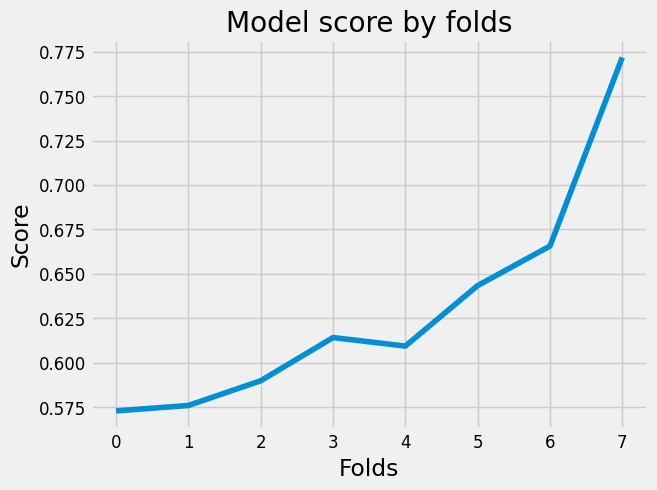

In [27]:
if not CFG.optimize and train_test == 'fold':
    sns.lineplot(x=list(range(len(conf_scores))), y=conf_scores)

    plt.title('Model score by folds')
    plt.xlabel('Folds')
    plt.xticks(fontsize=12)
    plt.ylabel('Score')
    plt.yticks(fontsize=12)

    plt.show()

### Distribution of model prediction scores

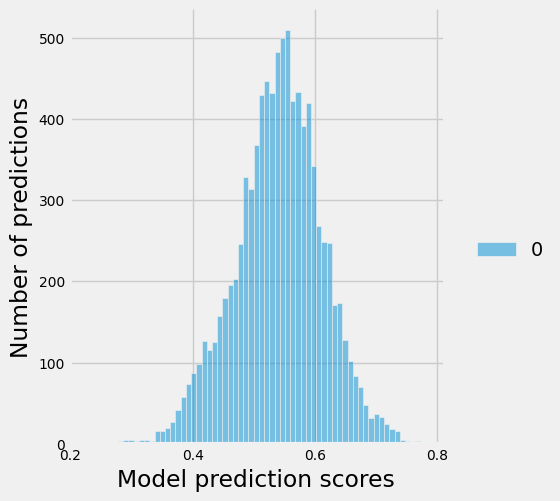

In [28]:
if not CFG.optimize and train_test == 'fold':
    sns.displot(oof)

    plt.xlabel('Model prediction scores')
    plt.xticks(fontsize=10)
    plt.ylabel('Number of predictions')
    plt.yticks(fontsize=10)

### Display PR curve for fold predictions

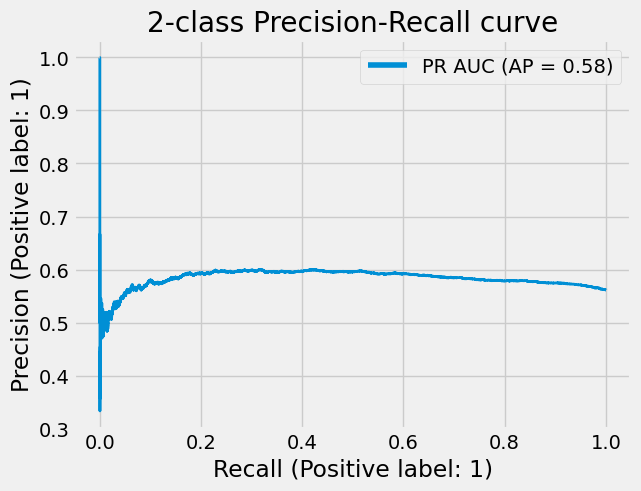

In [29]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc='upper right')
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.6

### Find the best threshold for fold predictions

ic| bound: 0.41
    score: 0.56807
    obj_num: 8939
    obj_pct: 0.96
    obj_profit: 1217
ic| bound: 0.411
    score: 0.5682
    obj_num: 8930
    obj_pct: 0.96
    obj_profit: 1218
ic| bound: 0.412
    score: 0.56842
    obj_num: 8916
    obj_pct: 0.95
    obj_profit: 1220
ic| bound: 0.413
    score: 0.56844
    obj_num: 8898
    obj_pct: 0.95
    obj_profit: 1218
ic| bound: 0.414
    score: 0.56858
    obj_num: 8887
    obj_pct: 0.95
    obj_profit: 1219
ic| bound: 0.415
    score: 0.56874
    obj_num: 8881
    obj_pct: 0.95
    obj_profit: 1221
ic| bound: 0.416
    score: 0.56885
    obj_num: 8867
    obj_pct: 0.95
    obj_profit: 1221
ic| bound: 0.417
    score: 0.56931
    obj_num: 8851
    obj_pct: 0.95
    obj_profit: 1227
ic| bound: 0.418
    score: 0.56936
    obj_num: 8845
    obj_pct: 0.95
    obj_profit: 1227
ic| bound: 0.419
    score: 0.56954
    obj_num: 8830
    obj_pct: 0.94
    obj_profit: 1228
ic| bound: 0.42
    score: 0.56971
    obj_num: 8815
    obj_pct: 0.94
 

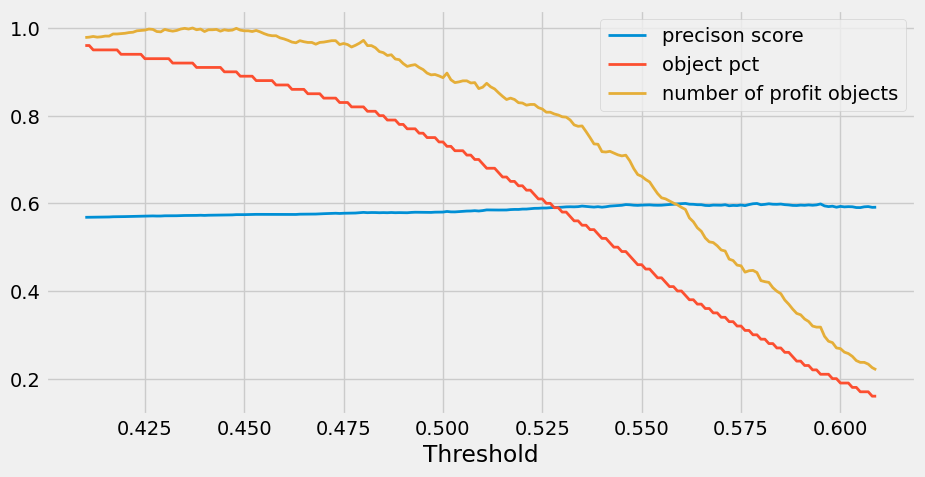

In [30]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    
    score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.41, 0.61, 0.001):
        score, obj_num, obj_pct = conf_ppv_npv_acc_score(y.reset_index(drop=True), oof, 0, hb)
        if score == 0:
            obj_num = 0
            obj_pct = 0
        bound, score, obj_num, obj_pct = round(hb, 4), round(score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * score - 1) * obj_num)
        score_list.append(score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.41, 0.61, 0.001), score_list, label='precison score', linewidth=2)
    line2 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_pct_list, label='object pct', linewidth=2)
    line3 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_profit_list, label='number of profit objects', linewidth=2)
    
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Test model

### Test model predictions on the new data

List of possible reasons of inconsistence between real and train predictions of tickers

- too small volume

- ticker was added to exchange not too much time ago

- different high_bound threshold

- there are NaNs in ticker dataframe

In [31]:
if not CFG.optimize and train_test == 'test':
    model = joblib.load('model/lgbm.pkl')
        
    with open(f'model/features.json', 'r') as f:
        features = json.load(f)['features']

    with open(f'model/bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred_proba'] = model.predict_proba(X[features])[:,1]
    X['pred'] = 0
    X.loc[X['pred_proba'] >= high_bound, 'pred'] = 1
    res = X.loc[((X['pred_proba'] >= high_bound)) & (X['time'] > CFG.last_date), ['time', 'ticker', 'ttype', 'pred', 'pred_proba', 'target', 'pattern']]
    res = res.reset_index(drop=True)
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))
    display(res)

### Plot rolling mean ppv_npv_acc score of the model predictions for the new data

In [32]:
if not CFG.optimize and train_test == 'test':
    figsize = (12, 5)
    plt.figure(figsize=figsize)

    tmp = res[res['pred'] == res['target']]
    tmp['ppv_npv_acc'] = tmp['target'].rolling(len(tmp), min_periods=1).count() / (tmp.index + 1)

    ax = sns.lineplot(x=tmp['time'], y=tmp['ppv_npv_acc'].values)
    ax.lines[0].set_linewidth(2)
    plt.xticks(rotation=45);

# Compare indicator / signal values for bot and optimizer

In [33]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x = x.drop(columns=['time_4h'])
# y = y.drop(columns=['time_4h'])
# x = x.ffill()
# x = x.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z = z.drop(columns=['time_4h'])
# v = v.drop(columns=['time_4h'])
# z = z.ffill()
# z = z.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])